# Application to image denoising

We will train the autoencoder to map noisy digits images to clean digits images.

We use the well-known MNIST dataset of hand-written digits, where each row contains the 28^2=784 raw gray-scale pixel values from 0 to 255 of the digitized digits (0 to 9).

## Load Keras, TensorFlow, and the MNIST training/testing datasets

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,8) # Make the figures a bit bigger

from keras.datasets import mnist
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model

Using TensorFlow backend.


In [2]:
# Seed for reproducibility
np.random.seed(42)

## Load training data

In [4]:
# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)

X_train original shape (60000, 28, 28)
y_train original shape (60000,)


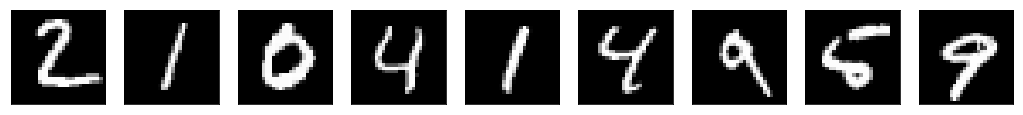

In [5]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n):
    ax = plt.subplot(1, n, i)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Format the data for training
Our neural-network is going to take a single vector for each training example, so we need to reshape the input so that each 28x28 image becomes a single 784 dimensional vector. We'll also scale the inputs to be in the range [0-1] rather than [0-255]

In [6]:
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# adapt this if using `channels_first` image data format
X_train = np.reshape(X_train, (len(X_train), 28, 28, 1))
X_test = np.reshape(X_test, (len(X_test), 28, 28, 1))

In [7]:
print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 28, 28, 1)
Testing matrix shape (10000, 28, 28, 1)


Here's how we will generate synthetic noisy digits: we just apply a gaussian noise matrix and clip the images between 0 and 1.

In [8]:
noise_factor = 0.5

X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape) 
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape) 

X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

Here's what the noisy digits look like:

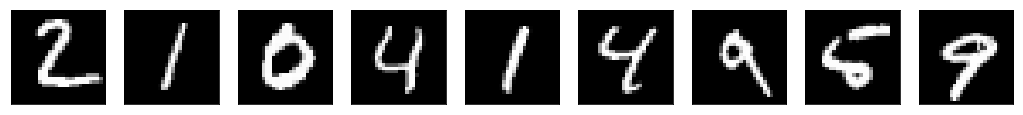

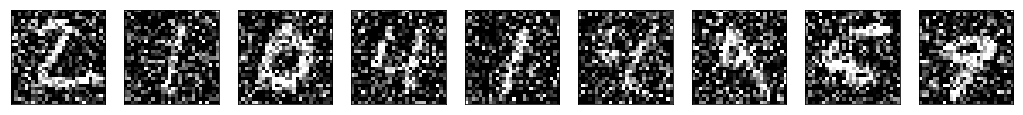

In [9]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n):
    ax = plt.subplot(1, n, i)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

plt.figure(figsize=(20, 2))
for i in range(1, n):
    ax = plt.subplot(1, n, i)
    plt.imshow(X_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

If you squint you can still recognize them, but barely. Can our autoencoder learn to recover the original digits? Let's find out.

## Define the Model

In [10]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

model = Model(input_img, decoded)
model.compile(loss='binary_crossentropy', optimizer='adadelta', )

In [11]:
# prints a summary representation of the model
# model.summary()

## Train the model

Let's train it for 1 epoch:

In [12]:
model.fit(X_train_noisy, X_train, epochs=1, batch_size=128, shuffle=True, validation_data=(X_test_noisy, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 232s - loss: 0.1935 - val_loss: 0.1310


## Visualize the result

Now let's take a look at the results. Top, the noisy digits fed to the network, and bottom, the digits are reconstructed by the network.

In [15]:
test_denoised = model.predict(X_test)

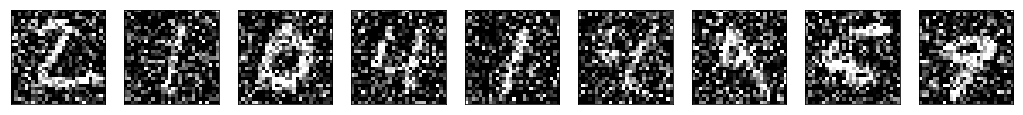

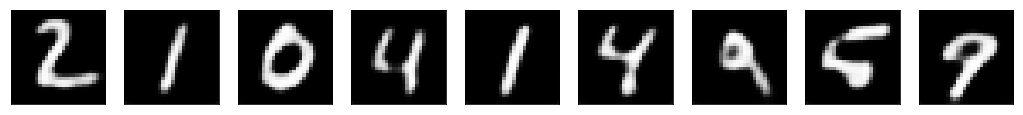

In [16]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n):
    ax = plt.subplot(1, n, i)
    plt.imshow(X_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

plt.figure(figsize=(20, 2))
for i in range(1, n):
    ax = plt.subplot(1, n, i)
    plt.imshow(test_denoised[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Voila!

It seems to work pretty well. If you scale this process to a bigger convnet, you can start building document denoising or audio denoising models.

[Kaggle has an interesting dataset to get you started.](https://www.kaggle.com/c/denoising-dirty-documents)